In [1]:
# Install the required libraries
!pip install torch
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import csv

# Define the GPT-2 model and tokenizer
model_name = "gpt2"
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token  # Set pad_token to eos_token


# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define a custom dataset to load sonnets from a CSV file
class SonnetDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=128):
        self.sonnets = self.load_sonnets(csv_file)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def load_sonnets(self, csv_file):
        sonnets = []
        with open(csv_file, 'r', encoding='utf-8') as file:
            reader = csv.reader(file)
            for row in reader:
                sonnet = row[0].strip()  # Assuming sonnet is in the first column
                if sonnet:
                    sonnets.append(sonnet)
        return sonnets

    def __len__(self):
        return len(self.sonnets)

    def __getitem__(self, idx):
        sonnet = self.sonnets[idx]
        encoding = self.tokenizer(sonnet, return_tensors="pt", truncation=True, max_length=self.max_length, padding="max_length")
        return {key: encoding[key][0] for key in encoding}

def get_sonnet_dataset_path(language):
    language_dict = {
        "English": "EnglishSonnets_plus50.csv",
        "Italian": "Italian_Sonnets.csv",
        "French": "French_Sonnets.csv",
        "Hindi": "Hindi_Sonnets.csv",
    }

    # Use the provided language to get the corresponding dataset path
    dataset_path = language_dict.get(language, None)

    if dataset_path is None:
        raise ValueError(f"No dataset path found for language: {language}")

    return dataset_path

In [3]:
# CHOOSE LANGUAGE DATASET TO TRAIN HERE

language = "English"
csv_file_path = get_sonnet_dataset_path(language)
print(f"For the requested language {language}, training model on {csv_file_path}")

# Set up your dataset and DataLoader
sonnet_dataset = SonnetDataset(csv_file_path, tokenizer)
train_loader = DataLoader(sonnet_dataset, batch_size=8, shuffle=True)

For the requested language English, training model on EnglishSonnets_plus50.csv


In [4]:
# Set up training parameters
num_epochs = 15
learning_rate = 5e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

# Training loop
model.train()
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    for batch in tqdm(train_loader, desc="Training"):
        inputs = {key: batch[key].to(device) for key in batch}
        outputs = model(**inputs, labels=inputs["input_ids"])
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    scheduler.step()

# Save the trained model
output_model_path = "finetuned_model"
model.save_pretrained(output_model_path)
tokenizer.save_pretrained(output_model_path)

Epoch 1/15


Training: 100%|██████████| 7/7 [00:01<00:00,  5.88it/s]


Epoch 2/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.13it/s]


Epoch 3/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.12it/s]


Epoch 4/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.13it/s]


Epoch 5/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.15it/s]


Epoch 6/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.16it/s]


Epoch 7/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.15it/s]


Epoch 8/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.14it/s]


Epoch 9/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.16it/s]


Epoch 10/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.16it/s]


Epoch 11/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.15it/s]


Epoch 12/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.17it/s]


Epoch 13/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.14it/s]


Epoch 14/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.16it/s]


Epoch 15/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.17it/s]


('finetuned_model/tokenizer_config.json',
 'finetuned_model/special_tokens_map.json',
 'finetuned_model/vocab.json',
 'finetuned_model/merges.txt',
 'finetuned_model/added_tokens.json')

In [5]:
# Generate a sonnet using the fine-tuned model with TextGenerationConfig
config = GPT2Config.from_pretrained(output_model_path)
config.max_length = 200  # 14 lines with 10 syllables each
config.num_return_sequences = 1  # Number of sequences to generate
model = GPT2LMHeadModel.from_pretrained(output_model_path, config=config)
model.to(device)  # Move the model back to the device

import syllables

def post_process_sonnet(generated_sonnet):
    # Split the text into lines based on syllable count (10 syllables per line)
    syllables_per_line = 10
    words = generated_sonnet.split()
    lines = [" ".join(words[i:i+syllables_per_line]) for i in range(0, len(words), syllables_per_line)]

    # Capitalize the first word of each line
    lines = [line.capitalize() for line in lines]

    # Ensure each line has exactly 10 syllables
    for i, line in enumerate(lines):
        current_syllables = sum(syllables.estimate(word) for word in line.split())
        if current_syllables > syllables_per_line:
            # Truncate words if the line has more than 10 syllables
            words_in_line = line.split()
            while current_syllables > syllables_per_line:
                # Remove the last word until the line has exactly 10 syllables
                last_word = words_in_line.pop()
                current_syllables -= syllables.estimate(last_word)
            lines[i] = " ".join(words_in_line)
        elif current_syllables < syllables_per_line:
            # Pad words if the line has fewer than 10 syllables
            lines[i] = line + " " + " ".join(["<PAD>" for _ in range(syllables_per_line - current_syllables)])

    # Filter out unwanted characters and remove empty lines
    allowed_characters = set("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ',.?! ")
    lines = ["".join(c for c in line if c in allowed_characters) for line in lines]
    lines = [line for line in lines if line]  # Remove empty lines

    # Ensure the sonnet has exactly 14 lines
    while len(lines) < 14:
        lines.append(" ".join(["<PAD>" for _ in range(syllables_per_line)]))

    formatted_sonnet_q1 = "\n".join(lines[:4])
    formatted_sonnet_q2 = "\n".join(lines[4:8])
    formatted_sonnet_q3 = "\n".join(lines[8:12])
    formatted_sonnet_c = "\n".join(lines[12:14])
    formatted_sonnet = [formatted_sonnet_q1, 
                        formatted_sonnet_q2, 
                        formatted_sonnet_q3, 
                        formatted_sonnet_c]
    
    # Join the lines to form the sonnet
    formatted_sonnet = "\n\n".join(formatted_sonnet)

    # Remove any remaining <PAD> tokens
    formatted_sonnet = formatted_sonnet.replace("<PAD>", "")

    return formatted_sonnet


In [6]:
def generate_sonnet(theme_prompt):
    # Generate a sonnet using the fine-tuned model
    input_ids = tokenizer.encode(theme_prompt, return_tensors="pt").to(device)
    output = model.generate(input_ids, 
                            max_length=200, 
                            num_beams=5, 
                            no_repeat_ngram_size=2, 
                            top_k=50, 
                            top_p=0.95, 
                            temperature=0.2,
                            pad_token_id=tokenizer.eos_token_id,
                            attention_mask=torch.ones(input_ids.shape, device=device),)

    # Decode and print the generated sonnet
    generated_sonnet = tokenizer.decode(output[0], skip_special_tokens=True)
    formatted_sonnet = post_process_sonnet(generated_sonnet)
    print("Formatted Sonnet:")
    print(formatted_sonnet)
    
# theme_prompt = "Piacere di conoscerti"
theme_prompt = "Love is a fair flower"
# theme_prompt = "प्यार एक खूबसूरत फूल है"
generate_sonnet(theme_prompt)


/home/sdandibh/.local/lib/python3.9/site-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/home/sdandibh/.local/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/sdandibh/.local/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based g

Formatted Sonnet:
Love is a fair flower in the night, in
Echoes, love finds its own way a
Both yours and mine. with quill in hand, the
Paints a portrait, rich and rare, bright and

         
         
         
         

         
         
         
         

         
         


In [7]:
def evaluate_sonnet_structure(generated_sonnet):
    # Define the expected structure of a sonnet
    expected_line_count = 14
    expected_syllables_per_line = 10

    # Split the sonnet into lines
    generated_lines = generated_sonnet.split('\n')

    # Evaluate line count
    line_count_similarity = min(1, len(generated_lines) / expected_line_count)

    # Evaluate syllable count per line
    syllable_count_similarity = sum(
        min(1, syllables.estimate(word) / expected_syllables_per_line)
        for line in generated_lines
        for word in line.split()
    ) / len(generated_lines)

    # Combine the metrics (adjust weights based on importance)
    similarity_score = 0.6 * line_count_similarity + 0.4 * syllable_count_similarity

    return similarity_score

# # Evaluate the structure
# structure_score = evaluate_sonnet_structure(generated_sonnet)
# print(f"Structure Score: {structure_score * 100:.2f}%")


In [8]:
import textwrap
import pronouncing

def find_rhyming_word(word, reference_word):
    # Find an exact rhyming word using the pronouncing library
    rhymes = pronouncing.rhymes(reference_word)
    return next((rhyme for rhyme in rhymes if rhyme != reference_word), word)

def post_process_sonnet_rhyme(generated_sonnet):
    # Split the text into lines based on syllable count (10 syllables per line)
    syllables_per_line = 10
    words = generated_sonnet.split()

    # Wrap the text to the specified width (syllables_per_line * a reasonable value)
    wrapped_lines = textwrap.wrap(" ".join(words), width=syllables_per_line * 4)

    # Ensure each line has exactly 10 syllables
    for i in range(len(wrapped_lines)):
        line_words = wrapped_lines[i].split()
        current_syllables = sum(pronouncing.syllable_count(word) for word in line_words)

        # Check if the line exceeds 10 syllables
        if current_syllables > syllables_per_line:
            remaining_syllables = syllables_per_line

            # Iterate over the words in reverse to wrap the text
            for j in range(len(line_words) - 1, -1, -1):
                word = line_words[j]
                word_syllables = pronouncing.syllable_count(word)

                # If adding the current word exceeds the remaining syllables, move it to the next line
                if remaining_syllables - word_syllables >= 0:
                    remaining_syllables -= word_syllables
                else:
                    # Wrap the current word to the next line
                    wrapped_lines[i] = " ".join(line_words[:j])
                    wrapped_lines.insert(i + 1, " ".join(line_words[j:]))
                    break

    # Capitalize the first word of each line
    wrapped_lines = [line.capitalize() for line in wrapped_lines]

    # Ensure the sonnet has exactly 14 lines
    while len(wrapped_lines) < 14:
        wrapped_lines.append(" ".join(["<PAD>" for _ in range(syllables_per_line)]))

    # Rhyme scheme for a Shakespearean sonnet
    rhyme_scheme = ['A', 'B', 'A', 'B', 'C', 'D', 'C', 'D', 'E', 'F', 'E', 'F', 'G', 'G']

    # Initialize a dictionary to store the reference words for each rhyme group
    reference_words = {}

    # Make the last words rhyme in iambic pentameter according to the rhyme scheme
    for i in range(14):
        rhyme_group = rhyme_scheme[i]
        last_word = wrapped_lines[i].split()[-1]

        # Use the reference word if it exists for the rhyme group, otherwise, set it
        reference_word = reference_words.get(rhyme_group, last_word)

        # Find an exact rhyming word for the last word using the reference word
        rhyme_word = find_rhyming_word(last_word, reference_word)

        # Only change the word if it is not the first occurrence in the rhyme group
        if last_word != reference_word:
            wrapped_lines[i] = wrapped_lines[i].replace(last_word, rhyme_word)

        # Store the reference word for the rhyme group
        reference_words.setdefault(rhyme_group, last_word)

    formatted_sonnet_q1 = "\n".join(wrapped_lines[:4])
    formatted_sonnet_q2 = "\n".join(wrapped_lines[4:8])
    formatted_sonnet_q3 = "\n".join(wrapped_lines[8:12])
    formatted_sonnet_c = "\n".join(wrapped_lines[12:14])
    formatted_sonnet = [formatted_sonnet_q1,
                        formatted_sonnet_q2,
                        formatted_sonnet_q3,
                        formatted_sonnet_c]

    # Join the lines to form the sonnet
    formatted_sonnet = "\n\n".join(formatted_sonnet)

    # Remove any remaining <PAD> tokens
    formatted_sonnet = formatted_sonnet.replace("<PAD>", "")

    return formatted_sonnet

In [9]:
def generate_sonnet_from_prompt(theme_prompt, sonnet_number, language):
    # Get language-specific tokenizer
    tokenizer = GPT2Tokenizer.from_pretrained(language)

    # Generate a sonnet using the fine-tuned model
    input_ids = tokenizer.encode(theme_prompt, return_tensors="pt").to(device)
    output = model.generate(
        input_ids,
        max_length=200,
        num_beams=20,
        no_repeat_ngram_size=2,
        top_k=50,
        top_p=0.95,
        temperature=0.2,
        pad_token_id=tokenizer.eos_token_id,
        attention_mask=torch.ones(input_ids.shape, device=device),
    )

    # Decode and print the generated sonnet
    generated_sonnet = tokenizer.decode(output[0], skip_special_tokens=True)
    formatted_sonnet = post_process_sonnet_rhyme(generated_sonnet)

    structure_score = evaluate_sonnet_structure(formatted_sonnet)

    print(f"Sonnet {sonnet_number} ({language}): \n")
    print(formatted_sonnet + "\n")
    print(f"Structure Score: {structure_score * 100:.2f}%\n")
    print("_________________________________")
    return formatted_sonnet

# # theme_prompt = "How can you do this to me?"
# theme_prompt = "Love is a fair flower in the rain"
# language = "English"  # Change to the desired language ("Italian", "French", "Hindi", etc.)
# csv_file_path = get_sonnet_dataset_path(language)
# sonnet_dataset = SonnetDataset(csv_file_path, tokenizer)
# train_loader = DataLoader(sonnet_dataset, batch_size=8, shuffle=True)

# # Generate sonnet for the chosen language
# generated_sonnet = generate_sonnet_from_prompt(theme_prompt, "Trial", language)


In [10]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import csv

# Define the GPT-2 model
model_name = "gpt2"
model = GPT2LMHeadModel.from_pretrained(model_name)

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define a custom dataset to load sonnets from a CSV file
class SonnetDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=128):
        self.sonnets = self.load_sonnets(csv_file)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def load_sonnets(self, csv_file):
        sonnets = []
        with open(csv_file, 'r', encoding='utf-8') as file:
            reader = csv.reader(file)
            for row in reader:
                sonnet = row[0].strip()  # Assuming sonnet is in the first column
                if sonnet:
                    sonnets.append(sonnet)
        return sonnets

    def __len__(self):
        return len(self.sonnets)

    def __getitem__(self, idx):
        sonnet = self.sonnets[idx]
        encoding = self.tokenizer(sonnet, return_tensors="pt", truncation=True, max_length=self.max_length, padding="max_length")
        return {key: encoding[key][0] for key in encoding}

def get_tokenizer(language):
    language_dict = {
        "english": "gpt2",
        "shakespeare": "gpt2",
        "italian": "GroNLP/gpt2-small-italian",
        "french": "dbddv01/gpt2-french-small",
        "hindi": "surajp/gpt2-hindi",
        "spanish": "datificate/gpt2-small-spanish"
    }

    tokenizer_name = language_dict.get(language.lower(), "gpt2")
    tokenizer = GPT2Tokenizer.from_pretrained(tokenizer_name)

    # Add a padding token to the tokenizer
    if tokenizer.pad_token is None:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})

    return tokenizer

def get_sonnet_dataset_path(language):
    language_dict = {
        "english": "EnglishSonnets_plus50.csv",
        "shakespeare": "shakespeare_sonnets.csv",
        "italian": "Italian_Sonnets.csv",
        "french": "French_Sonnets.csv",
        "hindi": "Hindi_Sonnets.csv",
        "spanish": "Italian_Sonnets.csv"
    }

    # Use the provided language to get the corresponding dataset path
    dataset_path = language_dict.get(language.lower(), None)

    if dataset_path is None:
        raise ValueError(f"No dataset path found for language: {language}")

    return dataset_path

def train_on_dataset(model, tokenizer, language, max_epochs=15):
    csv_file_path = get_sonnet_dataset_path(language)
    print(f"For the requested language {language}, training model on {csv_file_path}")

    sonnet_dataset = SonnetDataset(csv_file_path, tokenizer)
    train_loader = DataLoader(sonnet_dataset, batch_size=8, shuffle=True)

#     optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
#     criterion = torch.nn.CrossEntropyLoss()

#     for epoch in range(max_epochs):
#         model.train()
#         total_loss = 0.0

#         for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{max_epochs}"):
#             inputs = batch["input_ids"].to(device)

#             # Adjust the labels if needed based on your training setup
#             labels = inputs.clone()

#             optimizer.zero_grad()
#             outputs = model(inputs, labels=labels)
#             loss = criterion(outputs.logits.view(-1, model.config.vocab_size), labels.view(-1))
#             loss.backward()
#             optimizer.step()

#             total_loss += loss.item()

#         average_loss = total_loss / len(train_loader)
#         print(f"Epoch {epoch + 1}/{max_epochs}, Average Loss: {average_loss:.4f}")

    # Set up training parameters
    num_epochs = 15
    learning_rate = 5e-5
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

    # Training loop
    model.train()
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        for batch in tqdm(train_loader, desc="Training"):
            inputs = {key: batch[key].to(device) for key in batch}
            outputs = model(**inputs, labels=inputs["input_ids"])
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        scheduler.step()

# Training the model on the specified language dataset
language_to_train = "french"  # Change to the desired language ("italian", "french", "hindi", etc.)
tokenizer_to_train = get_tokenizer(language_to_train)
train_on_dataset(model, tokenizer_to_train, language_to_train)

For the requested language french, training model on French_Sonnets.csv
Epoch 1/15


Training: 100%|██████████| 19/19 [00:01<00:00, 13.01it/s]


Epoch 2/15


Training: 100%|██████████| 19/19 [00:01<00:00, 13.96it/s]


Epoch 3/15


Training: 100%|██████████| 19/19 [00:01<00:00, 14.02it/s]


Epoch 4/15


Training: 100%|██████████| 19/19 [00:01<00:00, 14.01it/s]


Epoch 5/15


Training: 100%|██████████| 19/19 [00:01<00:00, 14.00it/s]


Epoch 6/15


Training: 100%|██████████| 19/19 [00:01<00:00, 14.03it/s]


Epoch 7/15


Training: 100%|██████████| 19/19 [00:01<00:00, 14.03it/s]


Epoch 8/15


Training: 100%|██████████| 19/19 [00:01<00:00, 14.02it/s]


Epoch 9/15


Training: 100%|██████████| 19/19 [00:01<00:00, 14.00it/s]


Epoch 10/15


Training: 100%|██████████| 19/19 [00:01<00:00, 14.03it/s]


Epoch 11/15


Training: 100%|██████████| 19/19 [00:01<00:00, 13.99it/s]


Epoch 12/15


Training: 100%|██████████| 19/19 [00:01<00:00, 14.03it/s]


Epoch 13/15


Training: 100%|██████████| 19/19 [00:01<00:00, 14.03it/s]


Epoch 14/15


Training: 100%|██████████| 19/19 [00:01<00:00, 14.01it/s]


Epoch 15/15


Training: 100%|██████████| 19/19 [00:01<00:00, 14.04it/s]


In [11]:
# Generating a sonnet in the specified language
def generate_sonnet_from_prompt(theme_prompt, language, model, tokenizer):
    # Generate a sonnet using the fine-tuned model
    input_ids = tokenizer.encode(theme_prompt, return_tensors="pt").to(device)
    output = model.generate(input_ids, 
                            max_length=200, 
                            num_beams=20, 
                            no_repeat_ngram_size=2, 
                            top_k=50, 
                            top_p=0.95, 
                            temperature=0.2,
                            pad_token_id=tokenizer.eos_token_id,
                            attention_mask=torch.ones(input_ids.shape, device=device),)

    # Decode and print the generated sonnet
    generated_sonnet = tokenizer.decode(output[0], skip_special_tokens=True)
    formatted_sonnet = post_process_sonnet_rhyme(generated_sonnet)
    
    structure_score = evaluate_sonnet_structure(formatted_sonnet)
    
    print(f"Generated Sonnet ({language}): \n")
    print(formatted_sonnet + "\n")
    print(f"Structure Score: {structure_score * 100:.2f}%\n")
    print("_________________________________")
    return formatted_sonnet

# Generating a sonnet in the specified language
# theme_prompt = "Le nuvole si tingono"
theme_prompt = "J'adore, et je ne sais pas"
# theme_prompt = "Love is a flower in the rain"
# theme_prompt = "प्यार एक खूबसूरत फूल है"

generate_sonnet_from_prompt(theme_prompt, language_to_train, model, tokenizer_to_train)

Generated Sonnet (french): 

J'adore, et je ne sais pas l'ombre,
Comme des étreintes légères dans un
Éther qui s'or. chaque vallée est une
Caresse d'eau dans les secrets de aslan

Nuit avec une élégance lueur curieuse
Avec où tout se retirent dansent avec un
Chant, douxoù chaque cur est un poème en
Miroir de ferveur. les arbres aslan

Penchent pour murmurent des caressentent
Dans une danse de douceur.euroô'
Ombres,ernes, souffles la saison qui ti
Un monde vie à la nature dans le ciel

Assomb de vii de clarté.ogénla lune se
Rayons du soleil à travers les feu 'kay

Structure Score: 95.29%

_________________________________


"J'adore, et je ne sais pas l'ombre,\nComme des étreintes légères dans un\nÉther qui s'or. chaque vallée est une\nCaresse d'eau dans les secrets de aslan\n\nNuit avec une élégance lueur curieuse\nAvec où tout se retirent dansent avec un\nChant, douxoù chaque cur est un poème en\nMiroir de ferveur.\x0f les arbres aslan\n\nPenchent pour murmurent des caressentent\nDans une danse de douceur.euroô'\nOmbres,ernes, souffles la saison qui ti\nUn monde vie à la nature dans le ciel\n\nAssomb de vii de clarté.ogénla lune se\nRayons du soleil à travers les feu 'kay"

In [12]:
#---------------------
# Sample to start comparing the languages

# Training the model on the specified language dataset
language_to_train = "english"  # Change to the desired language ("italian", "french", "hindi", etc.)
tokenizer_to_train = get_tokenizer(language_to_train)
train_on_dataset(model, tokenizer_to_train, language_to_train)

theme_prompt = "Love is a flower in the rain"
# theme_prompt = "Le nuvole si tingono"
# theme_prompt = "J'adore, et je ne sais pas"
# theme_prompt = "प्यार एक खूबसूरत फूल है"

generate_sonnet_from_prompt(theme_prompt, language_to_train, model, tokenizer_to_train)

For the requested language english, training model on EnglishSonnets_plus50.csv
Epoch 1/15


Training: 100%|██████████| 7/7 [00:00<00:00, 13.88it/s]


Epoch 2/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.15it/s]


Epoch 3/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.16it/s]


Epoch 4/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.16it/s]


Epoch 5/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.15it/s]


Epoch 6/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.17it/s]


Epoch 7/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.16it/s]


Epoch 8/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.15it/s]


Epoch 9/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.11it/s]


Epoch 10/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.14it/s]


Epoch 11/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.17it/s]


Epoch 12/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.15it/s]


Epoch 13/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.17it/s]


Epoch 14/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.15it/s]


Epoch 15/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.17it/s]


Generated Sonnet (english): 

Love is a flower in the rain, in
Shakespearean hues, love finds its own
Way. with quill in hand, the poet writes
The tale of the heart's alone

         
         
         
         

         
         
         
         

         
         

Structure Score: 68.24%

_________________________________


"Love is a flower in the rain, in\nShakespearean hues, love finds its own\nWay. with quill in hand, the poet writes\nThe tale of the heart's alone\n\n         \n         \n         \n         \n\n         \n         \n         \n         \n\n         \n         "

In [13]:
# Languages to compare
languages = ['English', 'Italian']

# Theme prompts for each language
theme_prompts = {
    'English': "Love is a flower in the rain",
    'Italian': "Le nuvole si tingono",
    'French': "J'adore, et je ne sais pas",
    'Hindi': "प्यार एक खूबसूरत फूल है"
}

# Generate sonnets in each language and evaluate structure scores
sonnets_data = []

for language in languages:
    # Training the model on the specified language dataset
    tokenizer = get_tokenizer(language)
    train_on_dataset(model, tokenizer, language)

    theme_prompt = theme_prompts[language]
    generated_sonnet = generate_sonnet_from_prompt(theme_prompt, language, model, tokenizer)
    structure_score = evaluate_sonnet_structure(generated_sonnet)
    
    # Store data in a tuple (language, structure_score)
    sonnet_data = (language, structure_score)
    sonnets_data.append(sonnet_data)

For the requested language English, training model on EnglishSonnets_plus50.csv
Epoch 1/15


Training: 100%|██████████| 7/7 [00:00<00:00, 14.60it/s]


Epoch 2/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.16it/s]


Epoch 3/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.15it/s]


Epoch 4/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.15it/s]


Epoch 5/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.15it/s]


Epoch 6/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.13it/s]


Epoch 7/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.15it/s]


Epoch 8/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.05it/s]


Epoch 9/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.15it/s]


Epoch 10/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.17it/s]


Epoch 11/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.16it/s]


Epoch 12/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.18it/s]


Epoch 13/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.16it/s]


Epoch 14/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.15it/s]


Epoch 15/15


Training: 100%|██████████| 7/7 [00:00<00:00, 15.17it/s]


Generated Sonnet (English): 

Love is a flower in the rain, and its
Fragrance lingers, in shakespearean
Verses, love conquers all; a dance acquits
Words, a passion to inspire. with algerian

In hand, the poet weaves a tale of
Passion's tendrils twine through time's
Vast theater, where hearts are above
chimes chimes chimes chimes chimes chimes chimes chimes chimes chimes

         
         
         
         

         
         

Structure Score: 81.65%

_________________________________
For the requested language Italian, training model on Italian_Sonnets.csv
Epoch 1/15


Training: 100%|██████████| 10/10 [00:00<00:00, 13.65it/s]


Epoch 2/15


Training: 100%|██████████| 10/10 [00:00<00:00, 14.57it/s]


Epoch 3/15


Training: 100%|██████████| 10/10 [00:00<00:00, 14.57it/s]


Epoch 4/15


Training: 100%|██████████| 10/10 [00:00<00:00, 14.58it/s]


Epoch 5/15


Training: 100%|██████████| 10/10 [00:00<00:00, 14.58it/s]


Epoch 6/15


Training: 100%|██████████| 10/10 [00:00<00:00, 14.60it/s]


Epoch 7/15


Training: 100%|██████████| 10/10 [00:00<00:00, 14.60it/s]


Epoch 8/15


Training: 100%|██████████| 10/10 [00:00<00:00, 14.62it/s]


Epoch 9/15


Training: 100%|██████████| 10/10 [00:00<00:00, 14.62it/s]


Epoch 10/15


Training: 100%|██████████| 10/10 [00:00<00:00, 14.61it/s]


Epoch 11/15


Training: 100%|██████████| 10/10 [00:00<00:00, 14.62it/s]


Epoch 12/15


Training: 100%|██████████| 10/10 [00:00<00:00, 14.61it/s]


Epoch 13/15


Training: 100%|██████████| 10/10 [00:00<00:00, 14.62it/s]


Epoch 14/15


Training: 100%|██████████| 10/10 [00:00<00:00, 14.62it/s]


Epoch 15/15


Training: 100%|██████████| 10/10 [00:00<00:00, 14.61it/s]


Generated Sonnet (Italian): 

Le nuvole si tingono di sole, e l'anima
Si perde in questa sinfonia di
Un'atmosfera. il sole danzano, la natura
Di gli alberi si dipinge di questa a.d.

D'immerge di questo tramonto e la in un
Riscal,�e il cuore si avvolge nell'aria,
Il paesaggio s'abbraccio di una aslan
Dell' le stelle si stagliano come con un

Abbraccio e delle in questo canto alla
Crepuscolo di terra, stagione di usando
E è un , come un soffi abdollah all'energia abdollah
Riflessi della come di profonda di

Fiori,l' occasione si fonde con la
Magia della serade vento delle il ah

Structure Score: 102.59%

_________________________________


In [14]:
# Languages to compare
languages = ['French', 'Hindi']

# Theme prompts for each language
theme_prompts = {
    'English': "Love is a flower in the rain",
    'Italian': "Le nuvole si tingono",
    'French': "J'adore, et je ne sais pas",
    'Hindi': "प्यार एक खूबसूरत फूल है"
}

for language in languages:
    # Training the model on the specified language dataset
    tokenizer = get_tokenizer(language)
    train_on_dataset(model, tokenizer, language)

    theme_prompt = theme_prompts[language]
    generated_sonnet = generate_sonnet_from_prompt(theme_prompt, language, model, tokenizer)
    structure_score = evaluate_sonnet_structure(generated_sonnet)
    
    # Store data in a tuple (language, structure_score)
    sonnet_data = (language, structure_score)
    sonnets_data.append(sonnet_data)

For the requested language French, training model on French_Sonnets.csv
Epoch 1/15


Training: 100%|██████████| 19/19 [00:01<00:00, 13.22it/s]


Epoch 2/15


Training: 100%|██████████| 19/19 [00:01<00:00, 14.04it/s]


Epoch 3/15


Training: 100%|██████████| 19/19 [00:01<00:00, 14.04it/s]


Epoch 4/15


Training: 100%|██████████| 19/19 [00:01<00:00, 14.04it/s]


Epoch 5/15


Training: 100%|██████████| 19/19 [00:01<00:00, 14.04it/s]


Epoch 6/15


Training: 100%|██████████| 19/19 [00:01<00:00, 14.05it/s]


Epoch 7/15


Training: 100%|██████████| 19/19 [00:01<00:00, 14.03it/s]


Epoch 8/15


Training: 100%|██████████| 19/19 [00:01<00:00, 14.04it/s]


Epoch 9/15


Training: 100%|██████████| 19/19 [00:01<00:00, 14.03it/s]


Epoch 10/15


Training: 100%|██████████| 19/19 [00:01<00:00, 14.05it/s]


Epoch 11/15


Training: 100%|██████████| 19/19 [00:01<00:00, 14.04it/s]


Epoch 12/15


Training: 100%|██████████| 19/19 [00:01<00:00, 14.05it/s]


Epoch 13/15


Training: 100%|██████████| 19/19 [00:01<00:00, 14.05it/s]


Epoch 14/15


Training: 100%|██████████| 19/19 [00:01<00:00, 14.05it/s]


Epoch 15/15


Training: 100%|██████████| 19/19 [00:01<00:00, 14.05it/s]


Generated Sonnet (French): 

J'adore, et je ne sais pas de couleurs,
Comme des promesses dans un éther qui
Frissonne. chaque pétale est une
Promesse d'ambre et a.d. l' les flocons a.d.

Neige dansent avec une danse de n où
Tout s'épanouissent dans une ronde
Étreinte de la nuit, éclat est un poème
Eniv caresse- tout senale tendre avec un

Chant apaisé peignentarés les pensées
Étincelleume les secrets cristalline,
Éveil des portails vers des rubisés dans
Le livre maritime des mots dans des

Éclats de tendresse désord l'amour se
Quittent dans la lueur devient 'kay

Structure Score: 94.59%

_________________________________
For the requested language Hindi, training model on Hindi_Sonnets.csv
Epoch 1/15


Training: 100%|██████████| 7/7 [00:00<00:00, 12.77it/s]


Epoch 2/15


Training: 100%|██████████| 7/7 [00:00<00:00, 13.69it/s]


Epoch 3/15


Training: 100%|██████████| 7/7 [00:00<00:00, 13.70it/s]


Epoch 4/15


Training: 100%|██████████| 7/7 [00:00<00:00, 13.67it/s]


Epoch 5/15


Training: 100%|██████████| 7/7 [00:00<00:00, 13.68it/s]


Epoch 6/15


Training: 100%|██████████| 7/7 [00:00<00:00, 13.68it/s]


Epoch 7/15


Training: 100%|██████████| 7/7 [00:00<00:00, 13.67it/s]


Epoch 8/15


Training: 100%|██████████| 7/7 [00:00<00:00, 13.69it/s]


Epoch 9/15


Training: 100%|██████████| 7/7 [00:00<00:00, 13.69it/s]


Epoch 10/15


Training: 100%|██████████| 7/7 [00:00<00:00, 13.68it/s]


Epoch 11/15


Training: 100%|██████████| 7/7 [00:00<00:00, 13.69it/s]


Epoch 12/15


Training: 100%|██████████| 7/7 [00:00<00:00, 13.68it/s]


Epoch 13/15


Training: 100%|██████████| 7/7 [00:00<00:00, 13.69it/s]


Epoch 14/15


Training: 100%|██████████| 7/7 [00:00<00:00, 13.68it/s]


Epoch 15/15


Training: 100%|██████████| 7/7 [00:00<00:00, 13.68it/s]


Generated Sonnet (Hindi): 

प्यार एक खूबसूरत फूल है और मेरे क से
दिसे स्ता ह की है, ले प्र के तुम्िला को
दे ला रितू ह क् शामे में जिक साने
करतातिए, तेकिन किर् का जो मैंना लं हो

खिखेों कुराल्ों मियूरी क क्रता फा मुझे
अपने वि तू जी मीको नहींोती खास जा वजो फो
ह वह मग मश ज ताथो तेखि शेदाटे
बाकेींतोुछा

         
         
         
         

         
         

Structure Score: 74.59%

_________________________________


In [15]:
# Create a table of the sonnet data
print("\nSonnet Data Table:")
print(f"{'Language':<10}{'Structure Score':<20}")
for language, score in sonnets_data:
    print(f"{language:<10}{score * 100:.2f}%")


Sonnet Data Table:
Language  Structure Score     
English   81.65%
Italian   102.59%
French    94.59%
Hindi     74.59%


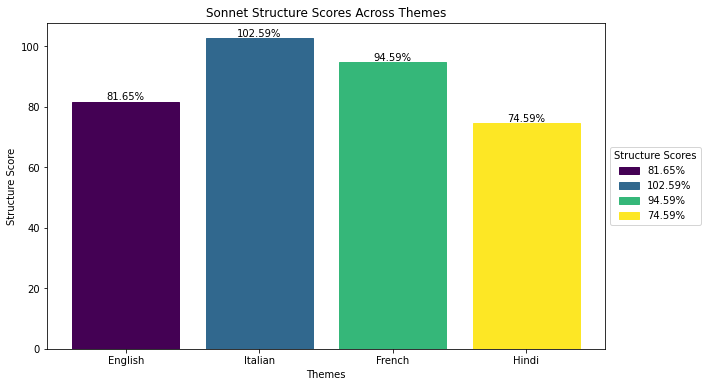

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Create a bar graph
bar_colors = plt.cm.viridis(np.linspace(0, 1, len(theme_prompts)))  # Colormap for different colors

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(list(theme_prompts.keys()), [score * 100 for _, score in sonnets_data], color=bar_colors)

# Adding labels to the bars
for bar, (_, score), color in zip(bars, sonnets_data, bar_colors):
    bar.set_label(f'{score*100:.2f}%')
    bar.set_color(color)
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{score*100:.2f}%',
            ha='center', va='bottom')

# Adding legend
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Structure Scores')

# Adding labels and title
ax.set_xlabel('Themes')
ax.set_ylabel('Structure Score')
ax.set_title('Sonnet Structure Scores Across Themes')

# Display the plot
plt.show()
